# University of science
## Advanced Machine Learning - Lab 06
## Nguyễn Quốc Bảo - 18110053

BT Tuần 06

1. Hãy dùng bộ FastText 300d để làm embedding cho model
2. Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây
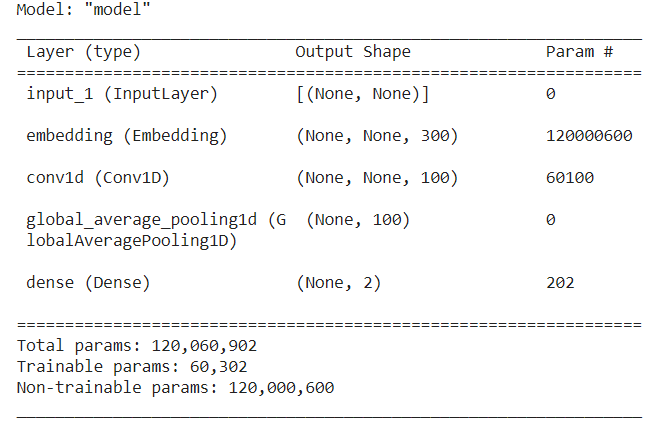

3. Xét 2 trường hợp trainable là True và False trong lớp embedding và đưa ra so sánh

* Lưu ý: Dùng data của bài thực hành số 5 để train 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from time import time
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, ReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#đọc data
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [3]:

nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]    # tách câu thành một list các từ

print(tokenized_texts[10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', "'m", 'gon', 'na', 'be', 'home', 'soon', 'and', 'i', 'do', "n't", 'want', 'to', 'talk', 'about', 'this', 'stuff', 'anymore', 'tonight', ',', 'k', '?', 'i', "'ve", 'cried', 'enough', 'today', '.']


1. Hãy dùng bộ FastText 300d để làm embedding cho model

# Load embedding 

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-11-20 04:34:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-20 04:34:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-20 04:34:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
import io
def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab, matrix = [], []
    i=0
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocab.append(tokens[0])
        matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix)

In [7]:
vocab, matrix = load_word_embeddings("glove.6B.300d.txt")

In [8]:
matrix.shape

(400000, 300)

In [9]:
## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding

In [10]:
word_to_index = {word: index+2 for index, word in enumerate(vocab)}

In [11]:
# Do do mã số được bắt đầu từ 2, nên cần thêm 2 vector vào đàu ma trận
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)
print(embedding_matrix.shape)

(400002, 300)


In [12]:
## Bây giờ ta sẽ chuyển data spam dection thành các mã số

X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        if word in word_to_index:
            cur_text_indices.append(word_to_index[word])    ## map từ word sang index
        else:
            cur_text_indices.append(__UNKNOWN_WORD__)       ## gán unknown cho từ không có trong bộ glove
    X.append(cur_text_indices)

## pad data cho có cùng chiều dài
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X,       # sequences: list các câu có độ dài không bằng nhau
                                                  padding='post')    # vị trí pad là 'pre' (trước) hoặc 'post' (sau)

y = df['y'].values   ## Label của bài toán, 0 là không phải spam, 1 là spam

In [13]:
print(X.shape)
print(y.shape)

(5574, 215)
(5574,)


# split data

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state =0)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.1)

In [16]:
X_train.shape

(4013, 215)

In [17]:

label2int = {"ham": 0, "spam": 1}
int2label = {0: "ham", 1: "spam"}

tokenizer = Tokenizer()

In [18]:
def get_predictions(text, dim=100):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=dim)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [19]:
compare_result = {'acc_model_1':[], 'time_model_1':[], 'acc_model_2':[], 'time_model_2':[]}

2. Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây
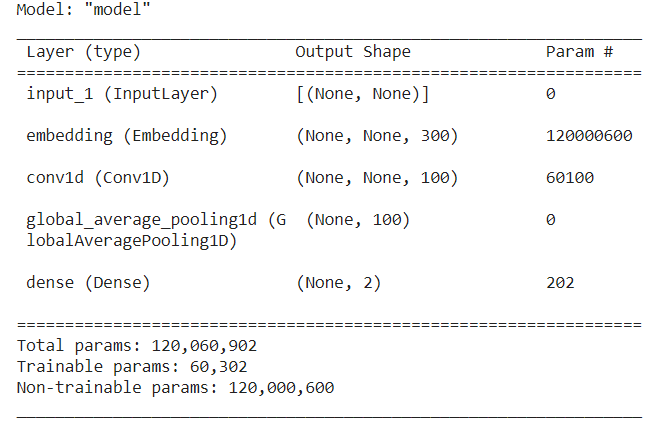

3. Xét 2 trường hợp trainable là True và False trong lớp embedding và đưa ra so sánh

Model 1

In [20]:
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

conv1d = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu')(embed)
global_maxpool = GlobalAveragePooling1D()(conv1d)
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense, name='model_1')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         120000600 
                                                                 
 conv1d (Conv1D)             (None, None, 100)         60100     
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 60,302
Non-trainable params: 120,000,600
________________________________________

In [21]:
start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid))
end = time()-start
print(end)
compare_result['time_model_1'].append(end)   

Epoch 1/10
32/32 [==============================] - 8s 207ms/step - loss: 0.5373 - accuracy: 0.8475 - val_loss: 0.4498 - val_accuracy: 0.8632
Epoch 2/10
32/32 [==============================] - 6s 202ms/step - loss: 0.4036 - accuracy: 0.8702 - val_loss: 0.3661 - val_accuracy: 0.8632
Epoch 3/10
32/32 [==============================] - 6s 196ms/step - loss: 0.3048 - accuracy: 0.8951 - val_loss: 0.2633 - val_accuracy: 0.9148
Epoch 4/10
32/32 [==============================] - 6s 196ms/step - loss: 0.2084 - accuracy: 0.9397 - val_loss: 0.1965 - val_accuracy: 0.9395
Epoch 5/10
32/32 [==============================] - 6s 195ms/step - loss: 0.1535 - accuracy: 0.9571 - val_loss: 0.1606 - val_accuracy: 0.9552
Epoch 6/10
32/32 [==============================] - 6s 196ms/step - loss: 0.1266 - accuracy: 0.9644 - val_loss: 0.1426 - val_accuracy: 0.9552
Epoch 7/10
32/32 [==============================] - 6s 199ms/step - loss: 0.1107 - accuracy: 0.9676 - val_loss: 0.1303 - val_accuracy: 0.9552
Epoch 

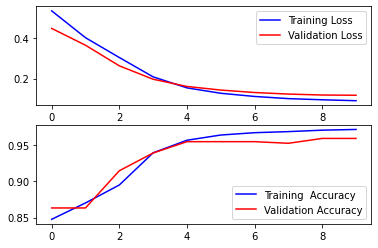

In [22]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [23]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_model_1'].append(val_acc) 

35/35 [==============================] - 1s 21ms/step - loss: 0.1092 - accuracy: 0.9623
Accuracy: 0.9623318314552307 and loss: 0.10915837436914444 on test


In [24]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [25]:
for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq,300))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



Model 2

In [26]:
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=True,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

conv1d = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu')(embed)
global_maxpool = GlobalAveragePooling1D()(conv1d)
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense, name='model_2')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         120000600 
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 120,060,902
Non-trainable params: 0
_____________________________________________

In [27]:

start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid))
end = time()-start
print(end)
compare_result['time_model_2'].append(end)   

Epoch 1/10
32/32 [==============================] - 46s 1s/step - loss: 0.4434 - accuracy: 0.8699 - val_loss: 0.3685 - val_accuracy: 0.8632
Epoch 2/10
32/32 [==============================] - 45s 1s/step - loss: 0.2929 - accuracy: 0.8732 - val_loss: 0.2327 - val_accuracy: 0.9081
Epoch 3/10
32/32 [==============================] - 45s 1s/step - loss: 0.1445 - accuracy: 0.9517 - val_loss: 0.1207 - val_accuracy: 0.9596
Epoch 4/10
32/32 [==============================] - 45s 1s/step - loss: 0.0737 - accuracy: 0.9776 - val_loss: 0.0909 - val_accuracy: 0.9709
Epoch 5/10
32/32 [==============================] - 45s 1s/step - loss: 0.0552 - accuracy: 0.9836 - val_loss: 0.0790 - val_accuracy: 0.9709
Epoch 6/10
32/32 [==============================] - 45s 1s/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0728 - val_accuracy: 0.9731
Epoch 7/10
32/32 [==============================] - 45s 1s/step - loss: 0.0343 - accuracy: 0.9905 - val_loss: 0.0684 - val_accuracy: 0.9798
Epoch 8/10
32/32 [==

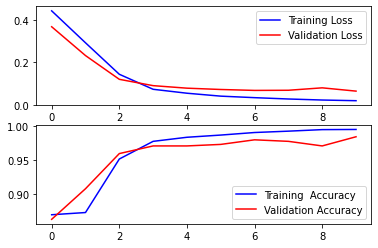

In [28]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [29]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_model_2'].append(val_acc) 

35/35 [==============================] - 1s 22ms/step - loss: 0.0520 - accuracy: 0.9865
Accuracy: 0.9865471124649048 and loss: 0.0519646517932415 on test


In [30]:
for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq,300))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



In [31]:
compare_result

{'acc_model_1': [0.9623318314552307],
 'acc_model_2': [0.9865471124649048],
 'time_model_1': [82.8402373790741],
 'time_model_2': [503.58119201660156]}

khi Trainable = False, nghĩa là lớp embedding này sẽ không cập nhật trọng số trong quá trình huấn luyện. Còn Khi Trainable = True, nghĩa là lớp embedding sẽ cập nhật trọng số trong quá trình huấn luyện. Có thể thấy là số param khi summary của 2 model:
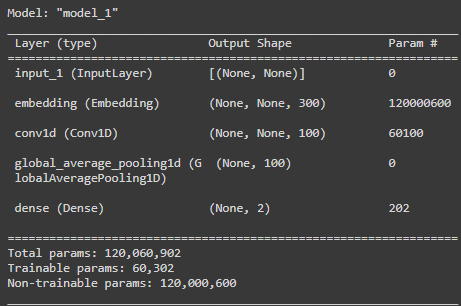

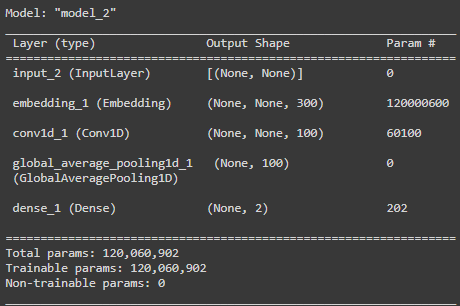



Chính vì model_2 cập nhật trọng số nhiều hơn nên thời gian huấn luyện sẽ cao hơn so với model_1. Còn về hiệu quả thì 2 model đều tốt trên tập data này.